In [37]:
import tensorflow as tf

In [38]:
print(tf.__version__)

2.9.1


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import os, random

In [3]:
def read_bin_to_array(filename):
    print(filename)
    sample = np.fromfile(filename, count=-1, dtype=np.single)
    return sample

In [4]:
def display_random_test_sample():
    # get range for each parameters
    filename = "trainset/" + random.choice(os.listdir("trainset")) 
    sample = read_bin_to_array(filename)
    plt.title("filename") 
    plt.plot(sample) 
    plt.show()

trainset/class_2_fmin_1_fmax_83_wlen_179_wphd_95.bin


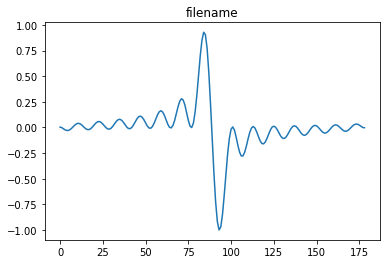

In [36]:
display_random_test_sample()